# REKOMENDASI MATERI BERDASARKAN BANYAKNYA KESALAHAN USER SAAT MENJAWAB SOAL

### IMPORT LIBRARY

In [2]:
!pip install keras-tuner


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt

### LOAD DATASET

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Dataset soal
file_path='dataset\Python Programming Questions Dataset.csv'
data = pd.read_csv(file_path)

# Tukar Input dan Output
data['Corrected_Input'] = data['Output']
data['Corrected_Output'] = data['Input']
data['text'] = data['Instruction'] + " " + data['Corrected_Input'] + " " + data['Corrected_Output']

# Menambah kolom materi
def categorize_question(Instruction):
    if re.search(r'\b(print|hello world|basic)\b', Instruction, re.IGNORECASE):
        return 'Introduction Python'
    elif re.search(r'\b(\+|\-|\*|\/|\%|\*\*|==|!=|<|>|<=|>=|=)\b', Instruction):
        return 'Operator'
    elif re.search(r'\b(int|float|string|bool|type)\b', Instruction, re.IGNORECASE):
        return 'Data Type'
    elif re.search(r'\b(list|tuple|dict|set|array)\b', Instruction, re.IGNORECASE):
        return 'Data Structure'
    elif re.search(r'\b(if|else|while|for|break|continue)\b', Instruction, re.IGNORECASE):
        return 'Control Structure'
    elif re.search(r'\b(def|function|return)\b', Instruction, re.IGNORECASE):
        return 'Function'
    elif re.search(r'\b(class|object|inheritance|method|self)\b', Instruction, re.IGNORECASE):
        return 'OOP'
    else:
        return 'Lainnya'

# Menerapkan pada dataset
data['materi'] = data['Instruction'].apply(categorize_question)

# Menambahkan kolom ID soal
data['question_id'] = data.index

# Dataset dummy interaksi user
interaction_data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3],
    'question_id': [0, 1, 1, 2, 2, 3, 4],
    'attempts': [3, 2, 4, 1, 3, 2, 1],
    'correct': [1, 0, 1, 1, 1, 0, 1],
    'duration': [30, 45, 60, 35, 50, 20, 25]
}
interaction_df = pd.DataFrame(interaction_data)

# Menggabungkan interaksi dengan soal
interaction_df = interaction_df.merge(data[['question_id', 'materi']], on='question_id', how='left')

### PREPROCESSING DATA

In [6]:
print(data.isnull().sum())

print(data.duplicated().sum())

data = data.dropna()

print(data.isnull().sum())


Instruction            0
Input               5549
Output                 0
Corrected_Input        0
Corrected_Output    5549
text                5549
materi                 0
question_id            0
dtype: int64
0
Instruction         0
Input               0
Output              0
Corrected_Input     0
Corrected_Output    0
text                0
materi              0
question_id         0
dtype: int64


In [7]:
# Fitur interaksi user
error_data = interaction_df.groupby('question_id').agg({
    'attempts': 'mean',
    'correct': 'mean',
    'duration': 'mean'
}).reset_index()

# Hitung kesalahan per materi
error_data['avg_error_rate'] = 1 - error_data['correct']
print(error_data)

# Representasi TF-IDF untuk teks
tfidf = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf.fit_transform(data['text']).toarray()

# Mendapatkan materi dengan kesalahan tertinggi
top_error_materis = error_data.sort_values(by='avg_error_rate', ascending=False).head(5)

# Menggabungkan fitur TF-IDF dengan kolom materi
features = pd.DataFrame(tfidf_matrix)

# Menambahkan kolom 'materi' ke dalam fitur
features['materi'] = data['materi']

# Encode target materi
data['target'] = data['materi'].astype('category').cat.codes
num_classes = len(data['target'].unique())

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features.drop('materi', axis=1), data['target'], test_size=0.2, random_state=42)

# One-hot encoding untuk target
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

   question_id  attempts  correct  duration  avg_error_rate
0            0       3.0      1.0      30.0             0.0
1            1       3.0      0.5      52.5             0.5
2            2       2.0      1.0      42.5             0.0
3            3       2.0      0.0      20.0             1.0
4            4       1.0      1.0      25.0             0.0



### MEMBANGUN MODEL


In [8]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='CodeyApp_recommendation_system'
)


# pencarian hyperparameter
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Mendapatkan hyperparameter yang bagus
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Reloading Tuner from model_tuning\CodeyApp_recommendation_system\tuner0.json


### TRAIN MODEL

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# Training model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/50
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2521 - loss: 2.8526
Epoch 1: val_loss improved from inf to 2.01514, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.2543 - loss: 2.8455 - val_accuracy: 0.4259 - val_loss: 2.0151 - learning_rate: 0.0010
Epoch 2/50
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6046 - loss: 1.6949
Epoch 2: val_loss improved from 2.01514 to 1.57212, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6047 - loss: 1.6943 - val_accuracy: 0.6667 - val_loss: 1.5721 - learning_rate: 0.0010
Epoch 3/50
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6594 - loss: 1.4743
Epoch 3: val_loss improved from 1.57212 to 1.27207, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6596 - loss: 1.4734 - val_accuracy: 0.7097 - val_loss: 1.2721 - learning_rate: 0.0010
Epoch 4/50
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accura

In [11]:
# Load best model yang tersimpan
model = tf.keras.models.load_model('best_model.h5')

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8312 - loss: 0.7163
Test Loss: 0.774288535118103
Test Accuracy: 0.8154761791229248


### PLOTTING

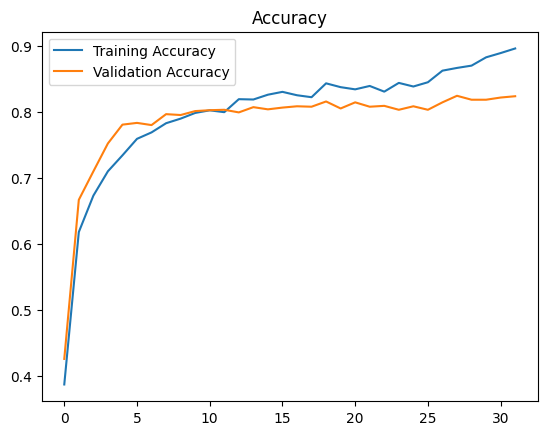

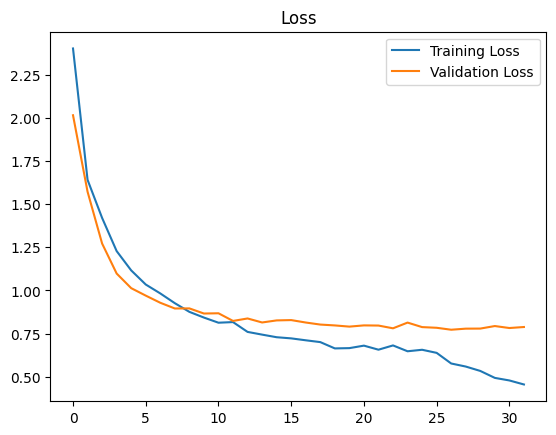

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


### MEMBANGUN REKOMENDASI

In [13]:
# Menghitung rata-rata kesalahan per materi
avg_error_per_materi = error_data.groupby(data['materi'])['avg_error_rate'].mean().reset_index()

# Mengurutkan materi berdasarkan tingkat kesalahan tertinggi
recommended_materials = avg_error_per_materi.sort_values(by='avg_error_rate', ascending=False)

# Tampilkan 5 materi dengan tingkat kesalahan tertinggi
print("Materi yang perlu dipelajari lebih lanjut (berdasarkan kesalahan siswa):")
print(recommended_materials.head())

Materi yang perlu dipelajari lebih lanjut (berdasarkan kesalahan siswa):
           materi  avg_error_rate
0  Data Structure            0.25


In [14]:
# Misalnya, prediksi materi untuk user berdasarkan interaksi mereka
# Data interaksi yang relevan
user_interaction = {
    'user_id': [4, 4, 4, 4, 4, 4, 4, 4],
    'question_id': [3, 4, 10, 14, 2, 19, 18],
    'attempts': [1, 1, 1, 1, 1, 1, 1, 1],
    'correct': [1, 1, 1, 0, 1, 1, 1, 1],
    'duration': [59, 30, 35, 20, 20, 20, 20,20]
}

user_interaction_df = pd.DataFrame(user_interaction)
user_interaction_df = user_interaction_df.merge(data[['question_id', 'materi']], on='question_id', how='left')

# Hitung rata-rata kesalahan per materi
user_error_data = user_interaction_df.groupby('materi').agg({
    'attempts': 'mean',
    'correct': 'mean',
    'duration': 'mean'
}).reset_index()

user_error_data['avg_error_rate'] = 1 - user_error_data['correct']

# Rekomendasikan materi dengan kesalahan tertinggi
user_recommended_materials = user_error_data.sort_values(by='avg_error_rate', ascending=False).head(1)
print("Materi yang perlu dipelajari oleh siswa:")
print(user_recommended_materials)


ValueError: All arrays must be of the same length

In [ ]:
model.save('best_model.keras')

In [ ]:
model.save('best_model.h5')

In [ ]:
# Load your trained model
model = tf.keras.models.load_model('best_model.h5')

# Memeriksa input shape dan dtype
print("Input shape:", model.input_shape)
print("Input dtype:", model.input_dtype)

Input shape: (None, 2000)
Input dtype: float32


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model TFLite
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpdbdovyw7\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpdbdovyw7\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmpdbdovyw7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2000), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2705647246928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705647254416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705647245584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705647255376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705647254800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705647249424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705649451472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705649452816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705649453200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705649451280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705649452240:

In [ ]:
import tensorflow as tf
import numpy as np

# Memuat model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Buat input dummy (pastikan format sesuai dengan model)
# Membuat data dummy dengan 1 sampel dan 2000 fitur
input_data = np.random.rand(1, 2000).astype(np.float32)

# Berikan data ke model
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil prediksi
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediction:", output_data)


Prediction: [[0. 0. 0. 0. 0. 1. 0. 0.]]
